# Optimization project

## Data preparation and common functions

In [13]:
#@title Import of the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix
import sys
eps = sys.float_info.epsilon
print(eps)
np.random.seed(1)

2.220446049250313e-16


In [14]:
#@title Creation of the toy dataset { form-width: "20%" }
#@markdown Here we can set some parameters to build our dataset.

from sklearn.datasets import make_blobs
n_samples = 1000        #@param ["5000", "1000", "500", "200"] {type:"raw", allow-input: true}
perc_imb = 0            #@param {type:"slider", min:0, max:0.5, step:0.05}
X, y = make_blobs(n_samples=[int(n_samples*(0.5-perc_imb)),
                             int(n_samples*(0.5+perc_imb))],
                             centers=None,
                             n_features=2,
                             cluster_std=[0.8, 0.8],
                             random_state=6)

# we changed the labels to be compliant with the problem proposed
y[y==0] = -1
n_pos = (y==1).sum()
n_neg = (y==-1).sum()
scaler = MinMaxScaler().fit(X)
X = scaler.transform(X)

# we keep only few of the label of the 2 cluster that we created
perc_neg = 0.03 #@param {type:"slider", min:0, max:0.1, step:0.01}
perc_pos = perc_neg
#perc_pos = 0.05 #@param {type:"slider", min:0, max:0.1, step:0.01}
n_labeled = int(n_neg * perc_neg) + int(n_pos * perc_pos)
index_neg = np.random.choice(np.where(y==-1)[0], size= int(n_neg * perc_neg), replace=False)
index_pos = np.random.choice(np.where(y==1)[0], size= int(n_pos * perc_pos), replace=False)

# create set of labelled and unlabelled X and y
index_labeled = np.concatenate((index_neg, index_pos))
X_labeled = X[index_labeled]
y_labeled = y[index_labeled]

n_unlabeled = n_samples - n_labeled
X_unlabeled = np.delete(X, index_labeled, axis=0)
y_unlabeled = np.delete(y, index_labeled)

# if we want to implement this method for general datasets we can just pick the labeled points at random
# hopefully they come from different clusters
#random_index_labeled = np.random.choice(n_samples, size = n_labeled)
# to color them in the right way in the plot i thing we can put some condition on the color
print("X labeled shape:", X_labeled.shape)
print("X unlabeled shape:", X_unlabeled.shape)
print("number of positive samples:", n_pos)
print("number of negative samples:", n_neg)

X labeled shape: (30, 2)
X unlabeled shape: (970, 2)
number of positive samples: 500
number of negative samples: 500


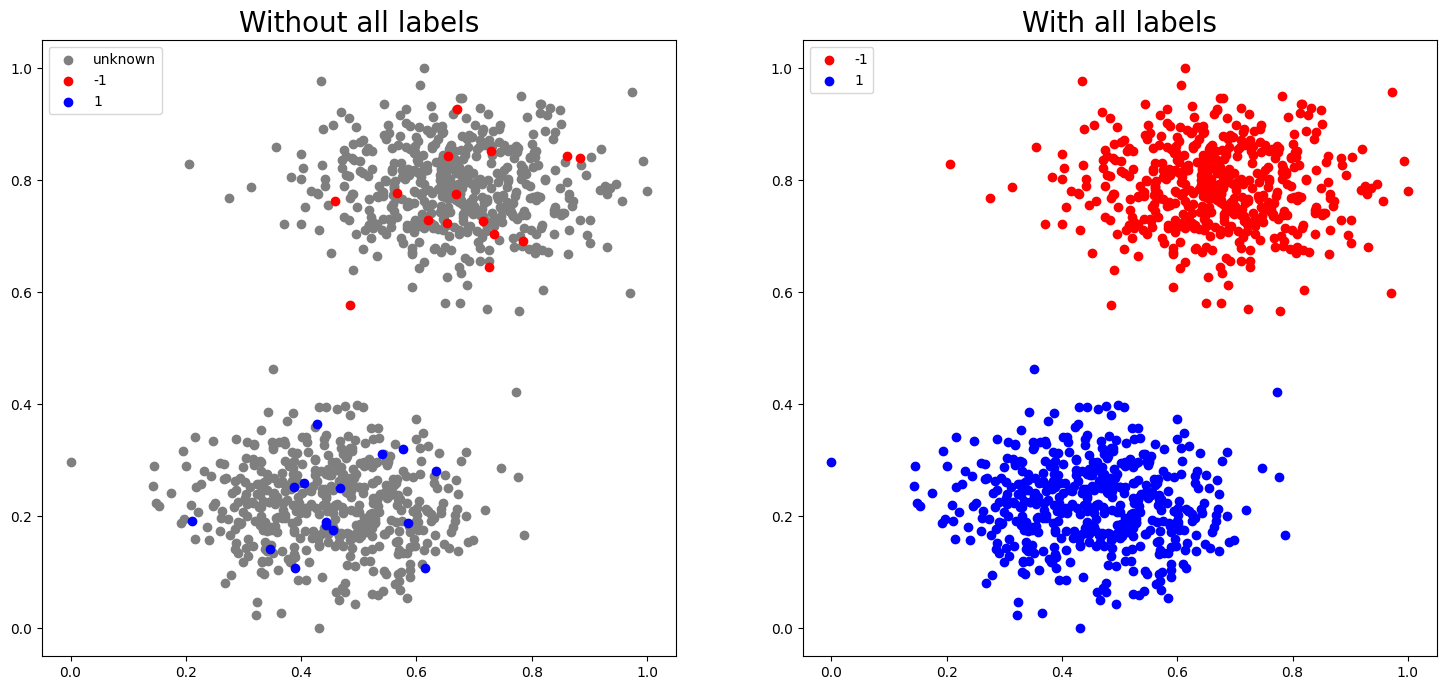

In [15]:
#@title Plots of our dataset vs Plot of the original dataset with all the labels
plt.figure(figsize=(18,8))

plt.subplot(1, 2, 1)
plt.title("Without all labels", fontsize=20)
plt.scatter(X_unlabeled[:, 0], X_unlabeled[:,1], c='tab:gray', label='unknown')
plt.scatter(X[:, 0][index_neg], X[:,1][index_neg], c='r', label='-1')
plt.scatter(X[:, 0][index_pos], X[:,1][index_pos], c='b', label='1')
plt.legend()

plt.subplot(1, 2, 2)
plt.title("With all labels", fontsize=20)
plt.scatter(X[:, 0][y==-1], X[:,1][y==-1], c='r', label='-1')
plt.scatter(X[:, 0][y== 1], X[:,1][y== 1], c='b', label='1')
plt.legend()

plt.show()

In [ ]:
#@title Class of the function
class Function():
    def __init__(self, compute_L):
        # weights
        self.W = np.zeros((n_labeled, n_unlabeled))
        self.Wuu = np.zeros((n_unlabeled, n_unlabeled))
        # call for initialization of weights
        self.init_weights()
        self.compute_L = compute_L
        # L computation
        if self.compute_L:
            tstart = time.time()
            self.H = np.zeros( (n_unlabeled, n_unlabeled) )
            self.compute_hessian()
            self.abs_eigs = abs(np.linalg.eig(self.H)[0])
            self.L = self.get_L()
            tend = time.time()
            self.sigma = self.get_sigma()
            self.ncond = self.L / self.sigma

            self.time_L = tend - tstart

    def init_weights(self):
        # init W
        for i in range(n_labeled):
            for j in range(n_unlabeled):
                self.W[i,j] = 1/(np.linalg.norm(X_labeled[i] - X_unlabeled[j]) + eps)
        # scale W
        aux = self.W.flatten()
        aux = (aux - aux.min()) / (aux.max() - aux.min())
        self.W = aux.reshape((X_labeled.shape[0], X_unlabeled.shape[0]))
        # init Wuu
        for i in range(n_unlabeled):
            for j in range(n_unlabeled):
                self.Wuu[i,j] = 1/(np.linalg.norm(X_unlabeled[i] - X_unlabeled[j]) + eps)
        #self.Wuu = 1 / (distance_matrix(X_unlabeled, X_unlabeled) + eps)
        # scale Wuu
        aux = self.Wuu.flatten()
        aux = (aux - aux.min()) / (aux.max() - aux.min())
        self.Wuu = aux.reshape((X_unlabeled.shape[0], X_unlabeled.shape[0]))

    def eval(self, y):
        sum1 = (self.W *  (y_labeled.reshape((y_labeled.shape[0], 1)) - y.reshape((1, y.shape[0])))**2 ).sum()
        sum2 = (self.Wuu *  (y.reshape((y.shape[0], 1)) - y.reshape((1, y.shape[0])))**2 ).sum()
        return sum1 + 0.5 * sum2

    def gradient(self, y, indexes=np.array(range(n_unlabeled))):
        grad = np.zeros(len(indexes))
        vett1 =  (self.W[:, indexes] * (y[indexes].reshape((len(indexes), 1)) - y_labeled.reshape( (1, y_labeled.shape[0]) )).T).sum(axis=0)
        vett2 = (self.Wuu[:, indexes] * (y[indexes].reshape( (len(indexes), 1) ) - y.reshape( (1, y.shape[0]) )).T).sum(axis=0)
        return 2 * (vett1 + vett2)

    def compute_hessian(self):
        self.H = - 2 * self.Wuu.copy()
        self.H += 2 * np.diag( (self.W.sum(axis=0)) + self.Wuu.sum(axis=0))

    def get_sigma(self):
        return self.abs_eigs.min()
    def get_L(self):
        return self.abs_eigs.max()

f = Function(compute_L = True)

In [ ]:
f = Function(compute_L = True)

In [ ]:
if f.compute_L:
    print(f'L = {f.L} has been computed in {f.time_L} seconds')

L = 2.1826402846098785 has been computed in 2.718407154083252 seconds


In [ ]:
f.ncond

34.539714597779934

In [ ]:
#@title armijo rule
def armijo(y, grad, alpha = 1, indexes=np.array(range(n_unlabeled))):
    delta = 0.4
    gamma = 0.1

    f_y = f.eval(y)
    dk = - grad
    gamma_gradT_dk = gamma * grad.dot(dk)
    skip = False

    step = np.copy(y)
    step[indexes] = y[indexes] + alpha * dk
    f_step = f.eval(step)
    while not f_step <= f_y + alpha * gamma_gradT_dk:
        alpha = delta * alpha
        step[indexes] = y[indexes] + alpha * dk
        f_step = f.eval(step)
        # print(alpha)
        if alpha <= 1e-16:
            skip = True
            break

    return alpha, f_step, skip

In [ ]:
def plot_results(err_history, time_history, method):

    last_iter = len(err_history)
    plt.figure(figsize=(9, 4))
    if method == 'GD':
      plt.suptitle("Gradient Descent Method - objective function")
    elif method == 'GS':
      plt.suptitle("BCGM Gauss-Southwell Method - objective function")
    else:
      plt.suptitle("BCGM Random Method - objective function")

    plt.subplot(1, 2, 1)
    plt.plot(range(last_iter), np.log10(err_history))
    plt.xlabel('Iter')
    plt.ylabel('log10(Error)')
    #plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(time_history, np.log10(err_history))
    plt.xlabel('Time')
    #plt.ylabel('log10(Error)')
    #plt.legend(loc='best')

    plt.show()

In [ ]:
def compare_scatterplot(y_pred):
    plt.figure(figsize=(18, 8))

    plt.subplot(1, 2, 1)
    plt.title("Predicted", fontsize=20)
    plt.scatter(X_unlabeled[:, 0][y_pred == -1], X_unlabeled[:,1][y_pred == -1], c='y', label='-1: predicted')
    plt.scatter(X_unlabeled[:, 0][y_pred == 1], X_unlabeled[:,1][y_pred == 1], c='c', label='1: predicted')
    plt.scatter(X[:, 0][index_neg], X[:,1][index_neg], c='r', label='-1: labeled')
    plt.scatter(X[:, 0][index_pos], X[:,1][index_pos], c='b', label='1: labeled')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Real", fontsize=20)
    plt.scatter(X_unlabeled[:, 0][y_unlabeled == -1], X_unlabeled[:,1][y_unlabeled == -1], c='y', label='-1: real')
    plt.scatter(X_unlabeled[:, 0][y_unlabeled == 1], X_unlabeled[:,1][y_unlabeled == 1], c='c', label='1: real')
    plt.scatter(X[:, 0][index_neg], X[:,1][index_neg], c='r', label='-1: labeled')
    plt.scatter(X[:, 0][index_pos], X[:,1][index_pos], c='b', label='1: labeled')
    plt.legend()

    plt.show()

## Gradient Method

In [ ]:
#@title Gradient descent method { form-width: "20%" }
np.random.seed(123)

# set parameters
epsilon = 0.1 #@param [1e-4, 1e-3, 1e-2, 1e-1, 1] {type:"raw", allow-input: true}
f_y_unlabeled = f.eval(y_unlabeled)
mode = "L" #@param ["L", "armijo"]

# choose random point y0
y0 = np.random.choice(np.array([-1,1]), size=n_unlabeled)
print('f(y_unlabeled):', f_y_unlabeled)
print('f(y0):', f.eval(y0), '\n')

# initialize global variables
stop = False
y_k = y0
f_y_k = f.eval(y_k)
s = 0
patience = 2
iteration = 0
verbose = True
skip = False

# variables for time-grad plots
err_history_GD = []
time_history_GD = []

# start time
start_time = time.time()

# start iteration --------------------------------------------------------------
while not (stop or skip):

  # compute the gradient
  grad = f.gradient(y_k)

  # f_old = f_y_k
  # update alpha
  if mode == 'armijo':
    alpha, f_y_k, skip = armijo(y_k, grad)
  else:
    alpha = 1 / f.L
  # update y_k
  y_k = y_k - alpha * grad

  # stopping criterion
  norm_grad = np.linalg.norm(grad)
  err_history_GD.append(norm_grad)    # update error history
  if norm_grad < epsilon:
    s += 1
    if s >= patience:
      stop = True
  else:
    s = 0

  # update iterations
  iteration += 1

  # update time history
  iter_time = time.time()
  time_history_GD.append(iter_time-start_time)

  if verbose and (iteration%10 == 0):
      if mode != 'armijo':
        f_y_k = f.eval(y_k)
      print('Iteration:', iteration, '\t f(y_k) =', f_y_k, '\t ||grad|| =', norm_grad)

# end iterations ---------------------------------------------------------------

# end time
end_time = time.time()

# print results

y_pred = np.apply_along_axis(np.vectorize(lambda x: 1 if x>0 else -1), axis=0, arr=y_k)

print('min f(y) =', f.eval(y_k))
print('f(y_pred) =', f.eval(y_pred))
print('number of misclassified data:', int(sum(abs(y_unlabeled - y_pred))/2), '\n')
print('running time:', end_time - start_time)
print('number of iterations:', iteration)
print('final grad norm:', np.linalg.norm(grad))

f(y_unlabeled): 59.015796327752646
f(y0): 342.56571398891083 

Iteration: 10 	 f(y_k) = 64.69336971895605 	 ||grad|| = 2.920104120304837
Iteration: 20 	 f(y_k) = 53.884295750574005 	 ||grad|| = 0.8014487727646535
Iteration: 30 	 f(y_k) = 52.84536174586704 	 ||grad|| = 0.29036536908630434
Iteration: 40 	 f(y_k) = 52.682360265372445 	 ||grad|| = 0.12800910954210842
min f(y) = 52.658194059240415
f(y_pred) = 59.020109542627985
number of misclassified data: 1 

running time: 0.511929988861084
number of iterations: 45
final grad norm: 0.09022504266478992


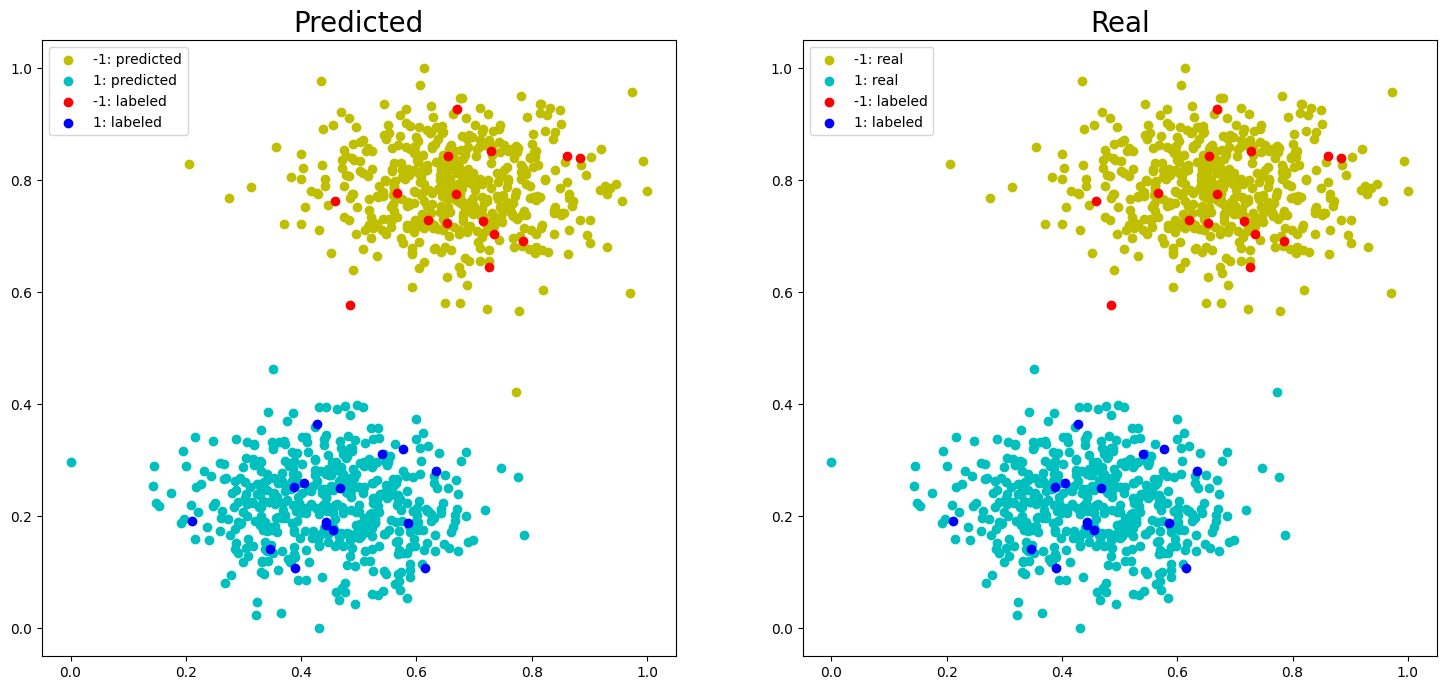

In [ ]:
compare_scatterplot(y_pred)

## BCGD

In [ ]:
#@title Function to create blocks
def create_blocks(dim_blocks):
    B = []
    b = int(n_unlabeled/dim_blocks)
    if n_unlabeled % dim_blocks == 0:
        b -= 1

    indexes = np.array(range(n_unlabeled))
    for i in range(b):
        B.append(np.random.choice(indexes, dim_blocks, replace=False))
        indexes = np.setdiff1d(indexes, B[i])
    B.append(indexes)

    return B

In [ ]:
#@title Randomized BCGD

# set parameters
epsilon = 0.1 #@param [1e-4, 1e-3, 1e-2, 1e-1, 1] {type:"raw", allow-input: true}

f_y_unlabeled = f.eval(y_unlabeled)
stop = False
verbose = True
dim_blocks = 1 #@param {type:"slider", min:1, max:100, step:1}
blocks = create_blocks(dim_blocks)
mode = "L" #@param ["L", "armijo"]

# choose random point y0
y0 = -1 + 2 * np.random.rand(n_unlabeled)
f_y0 = f.eval(y0)
print('f(y_unlabeled):', f_y_unlabeled)
print('f(y0):', f_y0, '\n')

# variables for time-grad plots
err_history_rBCGD = []
time_history_rBCGD = []

# initialize global variables
y_k = y0
f_y_k = f_y0
s = 0
it = 0
patience = n_unlabeled

# start time
start_time = time.time()

# start iteration --------------------------------------------------------------
while not stop:

    i = np.random.randint(len(blocks))
    b = blocks[i]

    if it == 0:
        list_subgrads = [f.gradient(y_k, indexes=block) for block in blocks]
        norm_subgrads = np.array([np.linalg.norm(subgrad)**2 for subgrad in list_subgrads])
        norm_grad_2 = np.sum(norm_subgrads)
    else:
        norm_grad_2 -= norm_subgrads[i]
        list_subgrads[i] = f.gradient(y_k, indexes=b)
        norm_subgrads[i] = np.linalg.norm(list_subgrads[i])**2
        norm_grad_2 += norm_subgrads[i]


    subgrad = list_subgrads[i]
    #subgrad = f.gradient(y_k, indexes=b)

    f_old = f_y_k

    # update alpha
    if mode == 'armijo':
      alpha, f_y_k, skip = armijo(y_k, subgrad, indexes=b)
    else:
      alpha = 1 / f.L

    # update y_k
    y_k[b] = y_k[b] - alpha * subgrad

    # update error history
    norm_grad = np.sqrt(norm_grad_2)
    err_history_rBCGD.append(norm_grad)

    # stopping criterion
    if norm_grad < epsilon:
      s += 1
      if s >= patience:
        stop = True
    else:
      s = 0


    # update iterations
    it += 1

    if verbose and (it%100 == 0):
        print('Iteration:', it, '  \tf(y_k) =', f_y_k, '\t ||grad|| =', norm_grad, '   \tb = ', b)

    # update time history
    iter_time = time.time()
    time_history_rBCGD.append(iter_time-start_time)

# end iterations ---------------------------------------------------------------

# end time
end_time = time.time()

# print results
y_pred = np.apply_along_axis(np.vectorize(lambda x: 1 if x>0 else -1), axis=0, arr=y_k)
print('min f(y) =', f.eval(y_k))
print('f(y_pred) =', f.eval(y_pred))
print('number of misclassified data:', int(sum(abs(y_unlabeled - y_pred)/2)), '\n')
print('running time:', end_time - start_time)
print('number of iterations:', it)
print('last alpha:', alpha)

f(y_unlabeled): 59.015796327752646
f(y0): 216.5177576097643 

Iteration: 100   	f(y_k) = 216.5177576097643 	 ||grad|| = 12.059135979715679    	b =  [181]
Iteration: 200   	f(y_k) = 216.5177576097643 	 ||grad|| = 12.008105409379072    	b =  [478]
Iteration: 300   	f(y_k) = 216.5177576097643 	 ||grad|| = 11.976855429779617    	b =  [715]
Iteration: 400   	f(y_k) = 216.5177576097643 	 ||grad|| = 11.854221008196282    	b =  [645]
Iteration: 500   	f(y_k) = 216.5177576097643 	 ||grad|| = 11.659954207447369    	b =  [398]
Iteration: 600   	f(y_k) = 216.5177576097643 	 ||grad|| = 11.6106352259664    	b =  [210]
Iteration: 700   	f(y_k) = 216.5177576097643 	 ||grad|| = 11.55243790264525    	b =  [958]
Iteration: 800   	f(y_k) = 216.5177576097643 	 ||grad|| = 11.476589330603003    	b =  [662]
Iteration: 900   	f(y_k) = 216.5177576097643 	 ||grad|| = 11.362738615880332    	b =  [176]
Iteration: 1000   	f(y_k) = 216.5177576097643 	 ||grad|| = 11.286761567057795    	b =  [929]
Iteration: 1100   	f

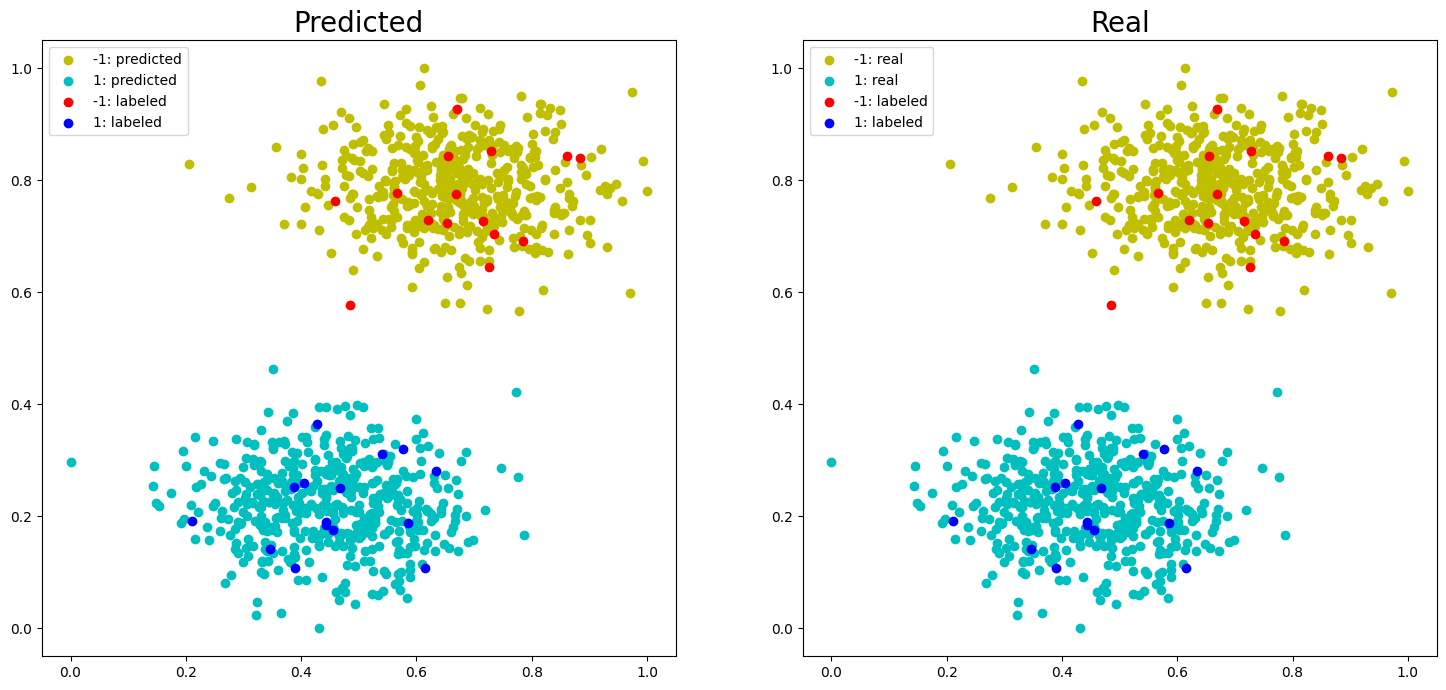

In [ ]:
compare_scatterplot(y_pred)

In [ ]:
#@title BCGD with GS rule

# set parameters
epsilon = 0.1 #@param [1e-4, 1e-3, 1e-2, 1e-1, 1] {type:"raw", allow-input: true}

f_y_unlabeled = f.eval(y_unlabeled)
stop = False
verbose = True
dim_blocks = 1 #@param {type:"slider", min:1, max:100, step:1}
blocks = create_blocks(dim_blocks)
mode = "L" #@param ["L", "armijo"]

# choose random point y0
y0 = -1 + 2 * np.random.rand(n_unlabeled)
f_y0 = f.eval(y0)
print('f(y_unlabeled):', f_y_unlabeled)
print('f(y0):', f_y0, '\n')

# variables for time-grad plots
err_history_GS = []
time_history_GS = []

# initialize global variables
y_k = y0
f_y_k = f_y0
s = 0
it = 0
patience = n_unlabeled

# start time
start_time = time.time()

# start iteration --------------------------------------------------------------
while not stop:

    # select random block in blocks
    if it == 0:
        list_subgrads = [f.gradient(y_k, indexes=block) for block in blocks]
        norm_subgrads = np.array([np.linalg.norm(subgrad)**2 for subgrad in list_subgrads])
        norm_grad_2 = np.sum(norm_subgrads)
    else:
        norm_grad_2 -= norm_subgrads[i_max]
        list_subgrads[i_max] = f.gradient(y_k, indexes=b)
        norm_subgrads[i_max] = np.linalg.norm(list_subgrads[i_max])**2
        norm_grad_2 += norm_subgrads[i_max]


    i_max = norm_subgrads.argmax()
    b = blocks[i_max]
    max_subgrad = list_subgrads[i_max]

    f_old = f_y_k

    # update alpha
    if mode == 'armijo':
      alpha, f_y_k, skip = armijo(y_k, max_subgrad, indexes=b)
    else:
      alpha = 1 / f.L

    # update y_k
    y_k[b] = y_k[b] - alpha * max_subgrad

    # update error history
    norm_grad = np.sqrt(norm_grad_2)
    err_history_GS.append(norm_grad)

    # stopping criterion
    if norm_grad < epsilon:
      s += 1
      if s >= patience:
        stop = True
    else:
      s = 0

    # update iterations
    it += 1

    if verbose and (it%100 == 0):
        print('Iteration:', it, '  \tf(y_k) =', f_y_k, '\t ||grad|| =', norm_grad, '  \t  b = ', b)

    # update time history
    iter_time = time.time()
    time_history_GS.append(iter_time-start_time)
# end iterations ---------------------------------------------------------------

# end time
end_time = time.time()

# print results
y_pred = np.apply_along_axis(np.vectorize(lambda x: 1 if x>0 else -1), axis=0, arr=y_k)
print('min f(y) =', f.eval(y_k))
print('f(y_pred) =', f.eval(y_pred))
print('number of misclassified data:', int(sum(abs(y_unlabeled - y_pred)/2)), '\n')
print('running time:', end_time - start_time)
print('number of iterations:', it)
print('last alpha:', alpha)

f(y_unlabeled): 59.015796327752646
f(y0): 218.79597586739652 

Iteration: 100   	f(y_k) = 218.79597586739652 	 ||grad|| = 9.821399753699515   	  b =  [143]
Iteration: 200   	f(y_k) = 218.79597586739652 	 ||grad|| = 9.209815380338044   	  b =  [643]
Iteration: 300   	f(y_k) = 218.79597586739652 	 ||grad|| = 8.72916902294275   	  b =  [429]
Iteration: 400   	f(y_k) = 218.79597586739652 	 ||grad|| = 8.328710338550977   	  b =  [850]
Iteration: 500   	f(y_k) = 218.79597586739652 	 ||grad|| = 7.9714682256310985   	  b =  [868]
Iteration: 600   	f(y_k) = 218.79597586739652 	 ||grad|| = 7.641307963069368   	  b =  [617]
Iteration: 700   	f(y_k) = 218.79597586739652 	 ||grad|| = 7.358179415229073   	  b =  [714]
Iteration: 800   	f(y_k) = 218.79597586739652 	 ||grad|| = 7.095874262243062   	  b =  [197]
Iteration: 900   	f(y_k) = 218.79597586739652 	 ||grad|| = 6.86088486908785   	  b =  [621]
Iteration: 1000   	f(y_k) = 218.79597586739652 	 ||grad|| = 6.6427726218995655   	  b =  [215]
Iterat

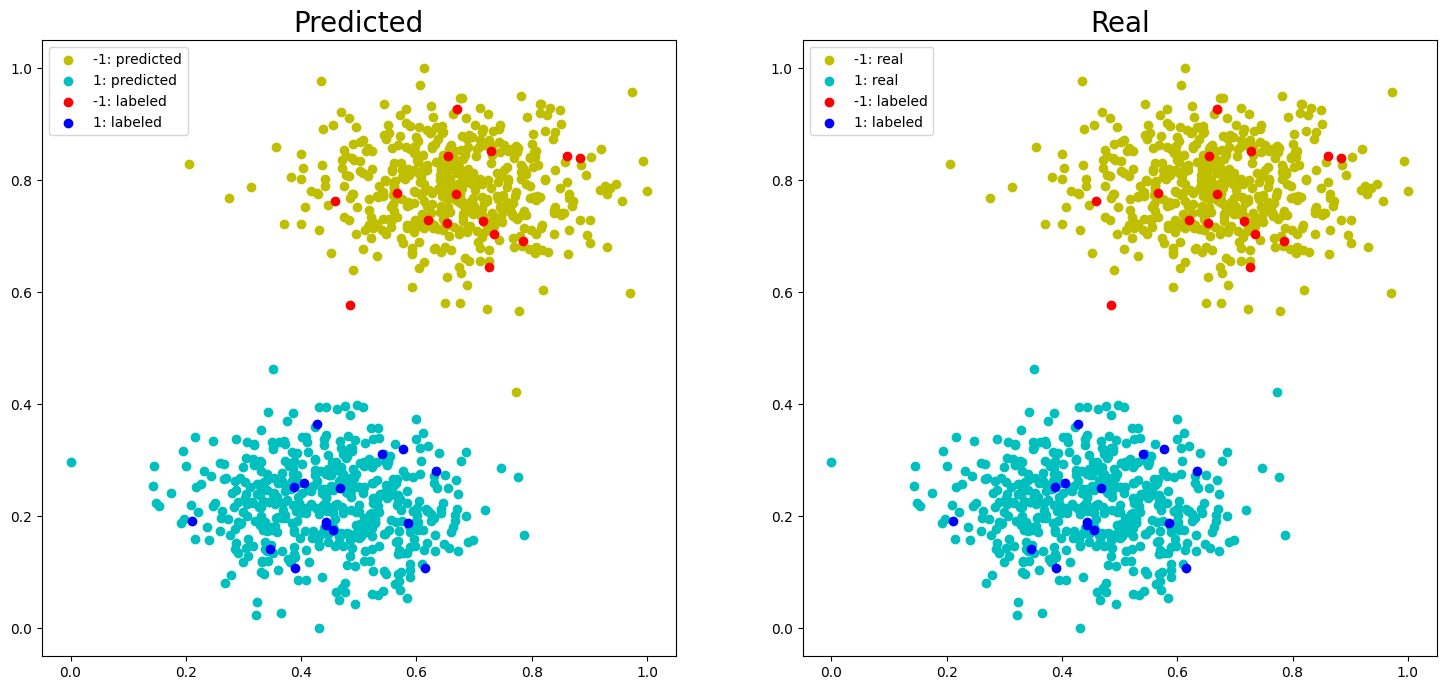

In [ ]:
compare_scatterplot(y_pred)

## Final plots

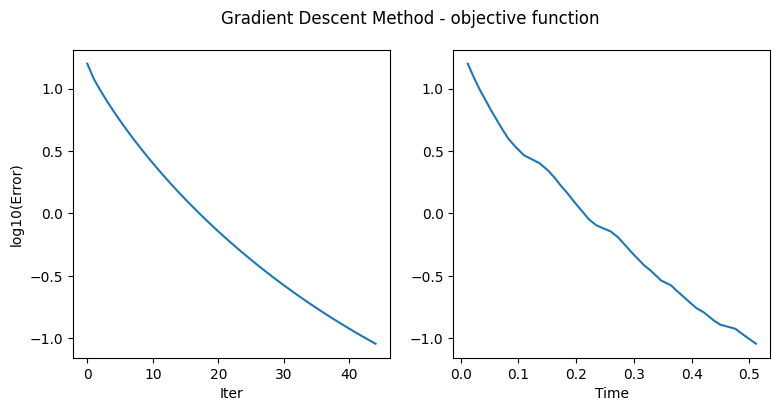

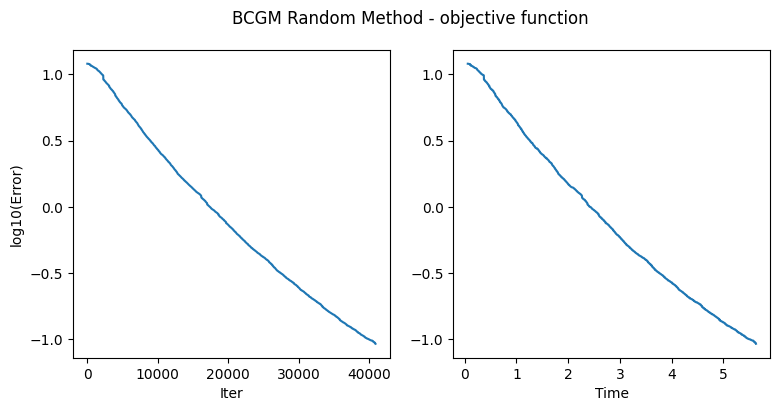

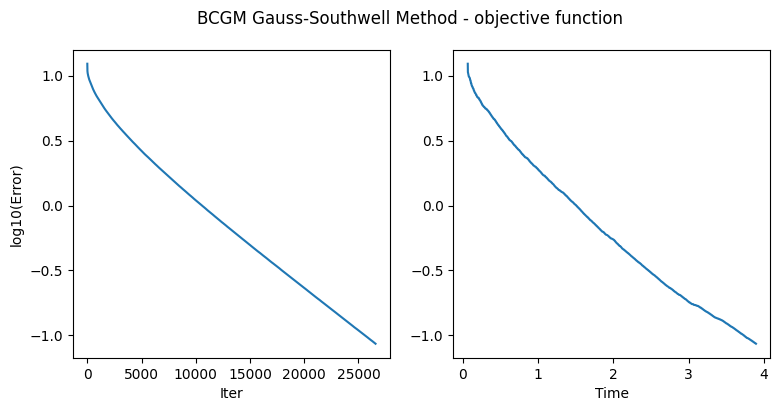

In [ ]:
plot_results(err_history_GD, time_history_GD, 'GD')
plot_results(err_history_rBCGD, time_history_rBCGD, 'r')
plot_results(err_history_GS, time_history_GS, 'GS')

In [ ]:
#@title Plot to compare different methods
def compare_convergence_rates():

    x_GD = np.array(range(len(err_history_GD)))
    x_rBCGD = np.array(range(len(err_history_rBCGD)))
    x_GS = np.array(range(len(err_history_GS)))
    plt.figure(figsize=(9, 4))
    plt.suptitle("Compare rates of methods with constant stepsize 1/L")

    plt.subplot(1, 2, 1)
    plt.plot(x_GD, np.log10(err_history_GD), label= 'Gradient Descent')
    plt.plot(x_rBCGD, np.log10(err_history_rBCGD), label= 'Randomized BCGD')
    plt.plot(x_GS, np.log10(err_history_GS), label= 'GS BCGD')
    plt.xlabel('Iteration')
    plt.ylabel('log10(Error)')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(time_history_GD, np.log10(err_history_GD), label= 'Gradient Descent')
    plt.plot(time_history_rBCGD, np.log10(err_history_rBCGD), label= 'Randomized BCGD')
    plt.plot(time_history_GS, np.log10(err_history_GS), label= 'GS BCGD')
    plt.xlabel('Time')
    #plt.ylabel('log10(Error)')
    plt.legend(loc='best')

    plt.show()

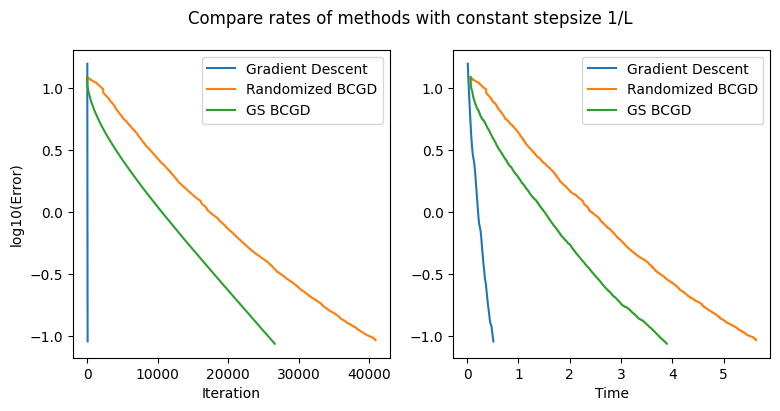

In [ ]:
compare_convergence_rates()